# Cost Estimation For IRIDE Costellation

## Imports

In [1]:
import pandas as pd
pd.set_option('expand_frame_repr', False)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# plt.style.use('_mpl-gallery')

## Costs

             Type  Date  Recurring (years)        Firm                                        Description  Cost (mil €)            Origin
0   Non-recurring  2023                  0         NaN                                        B1 Fix Cost         53.67               NaN
1       Recurring  2023                  6         NaN                                        B1 Var Cost        272.33               NaN
2       Recurring  2024                  6         NaN                                            B2 Cost        216.00               NaN
3   Non-recurring  2023                  0    Exprivia                        Payload Data Ground Segment         25.00     Their Website
4   Non-recurring  2023                  0  Telespazio                          Flight Operations Segment        100.00  NPV Costellation
5   Non-recurring  2023                  0      e-GEOS                         Development of Marketplace          1.00       Same as CDS
6       Recurring  2024           

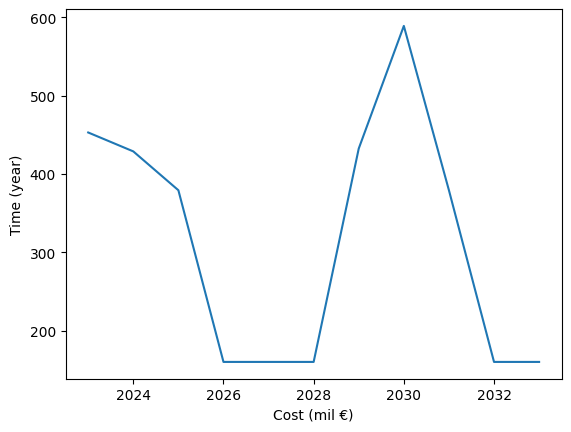

In [2]:
df_costs_sat = pd.read_csv('costs-satellites.csv')
# print(df_costs_sat)
df_costs_oth = pd.read_csv('costs-others.csv')
# df_costs_oth.info(memory_usage="deep")
print(df_costs_oth)
simulation_length = 11 # # of years
time = np.arange(
    np.min(df_costs_oth["Date"]),     # Begin of the simulation
    np.min(df_costs_oth["Date"]) + simulation_length # End of the simulation
    )
costs = np.zeros(simulation_length)
for index, row in df_costs_oth.iterrows():
    first_pos = row["Date"] - time[0]
    costs[first_pos] += row["Cost (mil €)"]
    if row["Recurring (years)"] > 0:
        first_pos += row["Recurring (years)"]
        while first_pos < simulation_length:
            costs[first_pos] += row["Cost (mil €)"]
            first_pos += row["Recurring (years)"]

plt.plot(time, costs)
plt.xlabel('Cost (mil €)')
plt.ylabel('Time (year)')
plt.show()

## Revenues

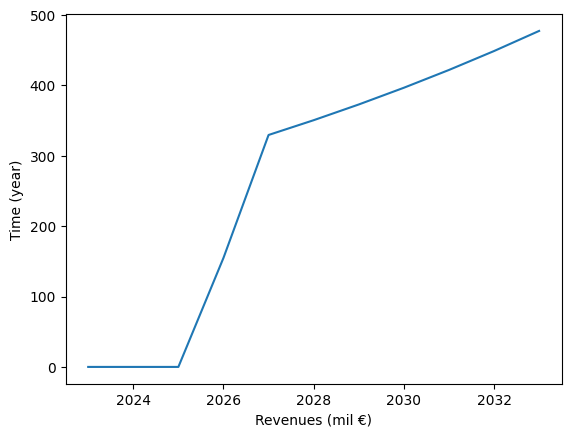

In [3]:
market_size_data_2023 = 100
market_size_data_2033 = 195
market_size_added_val_2023 = 415
market_size_added_val_2033 = 760
market_size_data_CAGR = (market_size_data_2033/market_size_data_2023)**(1/(2033-2023))-1
market_size_added_val_CAGR = (market_size_added_val_2033/market_size_added_val_2023)**(1/(2033-2023))-1

market_penetration = np.zeros(simulation_length)
market_penetration[time == 2026] = .25
market_penetration[time >  2026] = .5

revenues = np.zeros(simulation_length)
for ii in range(0,simulation_length):
    revenues[ii] = ((market_size_data_2023 * (1 + market_size_data_CAGR) ** ii + 
          market_size_added_val_2023 * (1 + market_size_added_val_CAGR) ** ii) * 
          market_penetration[ii])

plt.plot(time, revenues)
plt.xlabel('Revenues (mil €)')
plt.ylabel('Time (year)')
plt.show()

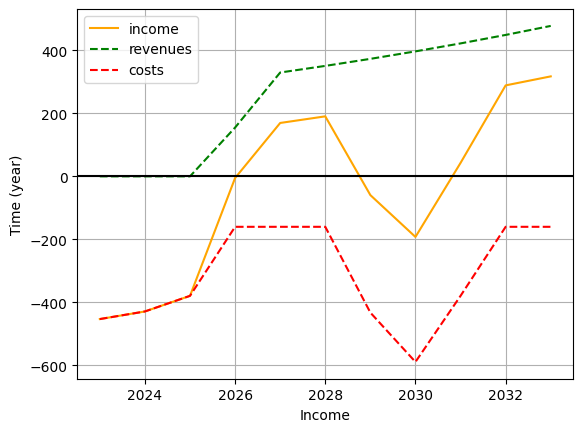

In [8]:
plt.plot(time, revenues - costs, color="orange")
plt.plot(time, revenues, "--", color="green")
plt.plot(time, -costs, "--", color="red")
plt.grid()
plt.xlabel('Income')
plt.ylabel('Time (year)')
plt.legend(["income", "revenues", "costs"])
plt.axhline(y=0, color='k')
plt.show()

## Financial Statements

In [10]:
class BalanceSheet():
    def __init__(self):
        self.total_current_assets = 0
        self.total_non_current_assets = 0
        self.total_equity = 0
        self.total_liability = 0
        return
    def get_total_assets(self):
        return self.total_current_assets + self.total_non_current_assets
    def get_total_equity_n_liability(self):
        return self.total_equity + self.total_liability

class IncomeStatement():
    def __init__(self):
        self.revenues = 0
        self.cost_of_revenues = 0
        self.operating_expenses = 0
        self.depreciation_n_amortizations = 0
        self.interest_expenses = 0
        self.tax_ratio = 0
        return
    def get_gross_profit(self):
        return self.revenues - self.cost_of_revenues
    def get_EBITDA(self):
        return self.get_gross_profit() - self.operating_expenses
    def get_EBIT(self):
        return self.get_EBITDA() - self.depreciation_n_amortizations
    def get_income_tax_expenses(self):
        return (self.get_EBIT() - self.interest_expenses) * self.tax_ratio
    def get_net_income(self):
        return (self.get_EBIT() - self.interest_expenses) * (1 - self.tax_ratio)

class CashFlowStatement():
    def __init__(self):
        self.operating_cf = 0
        self.investing_cf = 0
        self.financing_cf = 0
        return
    def get_net_change_in_cash(self):
        return self.operating_cf + self.investing_cf + self.financing_cf

class FinancialStatements():
    def __init__(self, first_year=2023, duration=10):
        self.first_year = first_year
        self.duration = duration
        self.statements = [{
                "year": year,
                "bsh": BalanceSheet(),
                "ist": IncomeStatement(),
                "cfs": CashFlowStatement()
            } for year in range(first_year, first_year + duration)
        ]
    def finance(self, year, amount, debt=False):
        yy = year - self.first_year
        if yy < 0 or yy > self.duration:
            raise ValueError("Finance transaction out of bound.")
        self.statements[yy].bsh.total_current_assets += amount
        self.statements[yy].cfs.financing_cf += amount
        if debt:
            self.statements[yy].bsh.total_liability += amount
        else:
            self.statements[yy].bsh.total_equity += amount
    def build_asset(self, year, amount, amortization_duration=5):
        pass
